In [1]:
#Referencing tutorials: 
# - https://medium.com/@lucrece.shin/chapter-3-transfer-learning-with-resnet50-from-dataloaders-to-training-seed-of-thought-67aaf83155bc
# - https://www.kaggle.com/code/pmigdal/transfer-learning-with-resnet-50-in-pytorch
# - https://www.youtube.com/watch?v=iYisBtT6zvs
# - https://www.geeksforgeeks.org/introduction-to-explainable-aixai-using-lime/
# - https://github.com/marcotcr/lime/blob/master/doc/notebooks/Tutorial%20-%20images%20-%20Pytorch.ipynb

#import the libraries for the data analysis
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import pandas as pd

#import the libraries relevent for pytorch
#will need to install pytorch: conda install pytorch torchvision torchaudio pytorch-cuda=11.8 -c pytorch -c nvidia
import torch
import torchvision

#import LIME
#install LIME for explanable AI (XAI) toolset: pip install lime
import lime

#insstall scikit images for image segmentation (LIME Highlighting)
#need to install scikit image: pip install scikit-image
import skimage

#import custom dataset
from PytorchDataset import NWB_Dataset

#Get the data
file_config = {
    "train" : {
        0  : "data/train/unit0.csv",
        1  : "data/train/unit1.csv",
        2  : "data/train/unit2.csv",
        3  : "data/train/unit3.csv",
        4  : "data/train/unit4.csv",
        5  : "data/train/unit5.csv",
        6  : "data/train/unit6.csv",
        7  : "data/train/unit7.csv",
        8  : "data/train/unit8.csv",
        9  : "data/train/unit9.csv",
        10 : "data/train/unit10.csv",
        11 : "data/train/unit11.csv",
        12 : "data/train/unit12.csv",
        13 : "data/train/unit13.csv",
        14 : "data/train/unit14.csv"
    },
    "validation": {
        0  : "data/validation/unit0.csv",
        1  : "data/validation/unit1.csv",
        2  : "data/validation/unit2.csv",
        3  : "data/validation/unit3.csv",
        4  : "data/validation/unit4.csv",
        5  : "data/validation/unit5.csv",
        6  : "data/validation/unit6.csv",
        7  : "data/validation/unit7.csv",
        8  : "data/validation/unit8.csv",
        9  : "data/validation/unit9.csv",
        10 : "data/validation/unit10.csv",
        11 : "data/validation/unit11.csv",
        12 : "data/validation/unit12.csv",
        13 : "data/validation/unit13.csv",
        14 : "data/validation/unit14.csv"
    }
}
unit_used = 1 #3
num_epochs = 150
train_dataloader = torch.utils.data.DataLoader(
    NWB_Dataset(file_config, unit=unit_used, train=True),
    batch_size=16,
    shuffle=True
    #num_workers=2
)

#select the device to run the model on: GPU or CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#obtain a pretrained ResNet50 model
#model = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)
model = torchvision.models.resnet50(weights=None)
#freeze all the gradients to prevent them from changing
#for param in model.parameters():
#    param.requires_grad = False
#change the last layer of the model to return the average spike rate at each time bin (30 bins: -1 to 3 seconds after image onset)
model.fc = torch.nn.Linear(in_features=2048, out_features=1)
model = model.to(device) #ensure the model is sent to cuda after parameters are changed
#define the loss function: SmoothL1Loss for stable loss computation (L2 near 0 and L1 beyond +/-beta)
loss_function = torch.nn.SmoothL1Loss(beta=1.0)
#define the optimizer: adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)

#Define the model training process
model.train()
loss_per_epoch = list()
current_loss = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_dataloader):
        #print(images)
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = loss_function(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        current_loss += loss.item()
        if((i+1)%3 == 0):
            #print the current epoch, batch (step), and current model loss
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_dataloader)}], Loss: {loss.item():.4f}")
        if(i == len(train_dataloader)-1):
            loss_per_epoch.append(current_loss)
            current_loss = 0

Epoch [1/150], Step [3/6], Loss: 0.9232
Epoch [1/150], Step [6/6], Loss: 1.4185
Epoch [2/150], Step [3/6], Loss: 0.8235
Epoch [2/150], Step [6/6], Loss: 0.8030
Epoch [3/150], Step [3/6], Loss: 0.9330
Epoch [3/150], Step [6/6], Loss: 0.8657
Epoch [4/150], Step [3/6], Loss: 0.7995
Epoch [4/150], Step [6/6], Loss: 1.0208
Epoch [5/150], Step [3/6], Loss: 1.2149
Epoch [5/150], Step [6/6], Loss: 0.9104
Epoch [6/150], Step [3/6], Loss: 0.7319
Epoch [6/150], Step [6/6], Loss: 0.9504
Epoch [7/150], Step [3/6], Loss: 0.6575
Epoch [7/150], Step [6/6], Loss: 0.7041
Epoch [8/150], Step [3/6], Loss: 0.9058
Epoch [8/150], Step [6/6], Loss: 0.8558
Epoch [9/150], Step [3/6], Loss: 0.7756
Epoch [9/150], Step [6/6], Loss: 0.8982
Epoch [10/150], Step [3/6], Loss: 0.7434
Epoch [10/150], Step [6/6], Loss: 0.5665
Epoch [11/150], Step [3/6], Loss: 0.8724
Epoch [11/150], Step [6/6], Loss: 0.9639
Epoch [12/150], Step [3/6], Loss: 0.6362
Epoch [12/150], Step [6/6], Loss: 0.4457
Epoch [13/150], Step [3/6], Loss: 

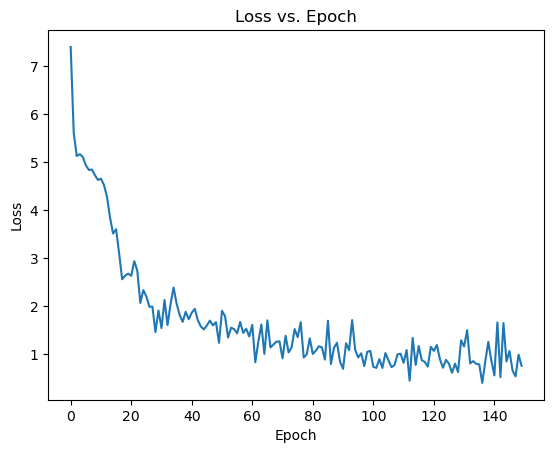

In [2]:
plt.plot(loss_per_epoch)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs. Epoch")
plt.show()

In [3]:

validation_dataloader = torch.utils.data.DataLoader(
    NWB_Dataset(file_config, unit=unit_used, train=False),
    batch_size=32,
    shuffle=False
    #num_workers=2
)

model.eval()
print("True | Predicted | Error")
for i, (images, labels) in enumerate(validation_dataloader):
    #print(images)
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    loss = loss_function(outputs, labels)

    for i in range(len(labels)):
        print(f"{labels[i].item():.3f}, {outputs[i].item():.3f}, {outputs[i].item()-labels[i].item():.3f}")
    print("-----")
    print(f"Loss: {loss.item():.4f}")

True | Predicted | Error
0.667, 1.107, 0.440
3.333, 1.830, -1.504
4.667, 0.973, -3.694
4.000, 0.300, -3.700
2.667, 0.622, -2.045
2.000, 1.815, -0.185
4.000, 1.763, -2.237
0.667, 0.925, 0.258
2.000, 1.316, -0.684
2.667, 2.068, -0.598
-----
Loss: 1.1239


=====IMAGE 0=====


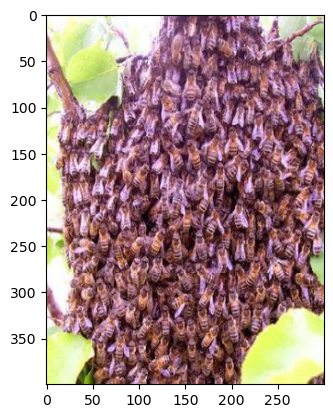

c:\Users\mike5\anaconda3\envs\COGS108\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 1000/1000 [00:08<00:00, 116.27it/s]


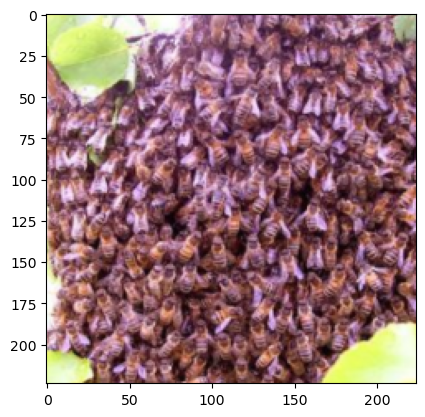

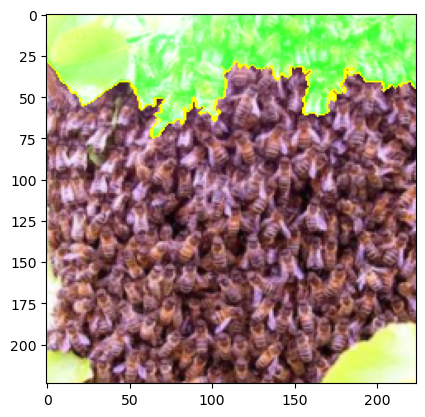

=====IMAGE 1=====


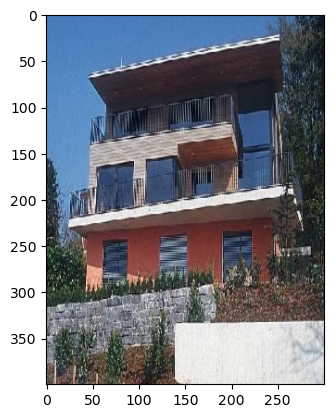

100%|██████████| 1000/1000 [00:08<00:00, 122.33it/s]


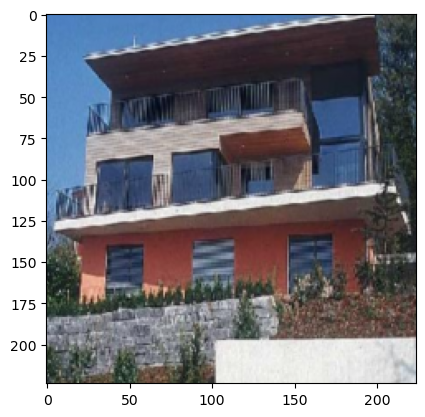

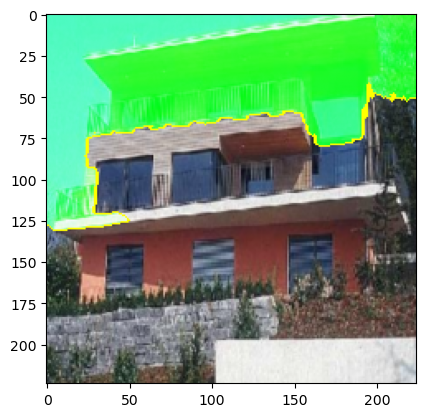

=====IMAGE 2=====


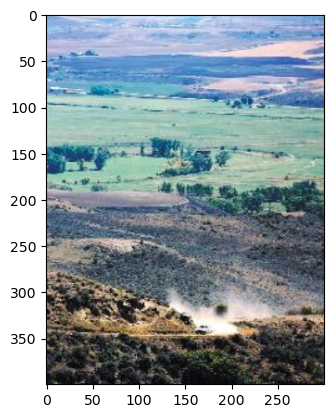

100%|██████████| 1000/1000 [00:07<00:00, 129.06it/s]


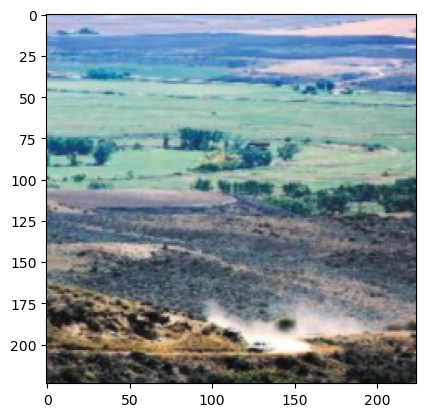

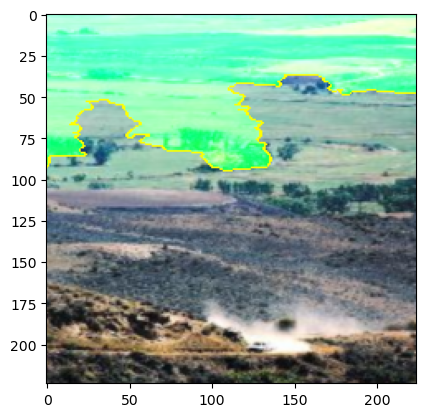

=====IMAGE 3=====


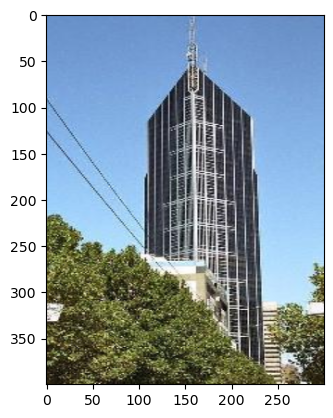

100%|██████████| 1000/1000 [00:08<00:00, 124.20it/s]


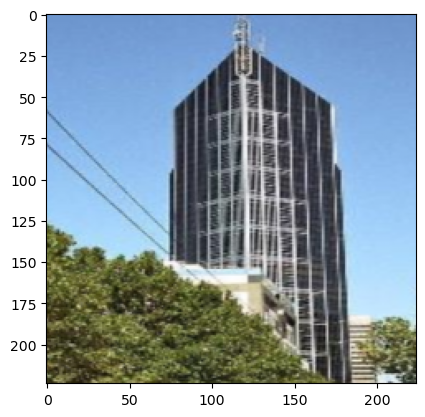

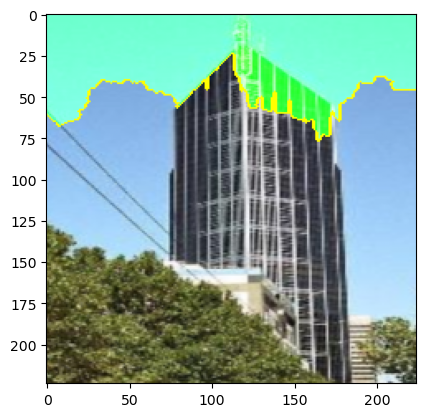

=====IMAGE 4=====


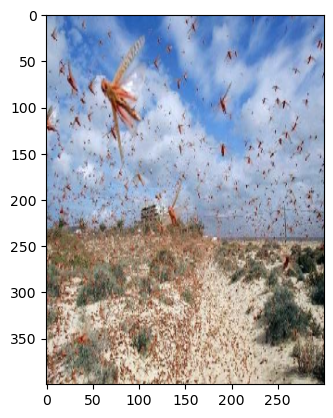

100%|██████████| 1000/1000 [00:08<00:00, 113.16it/s]


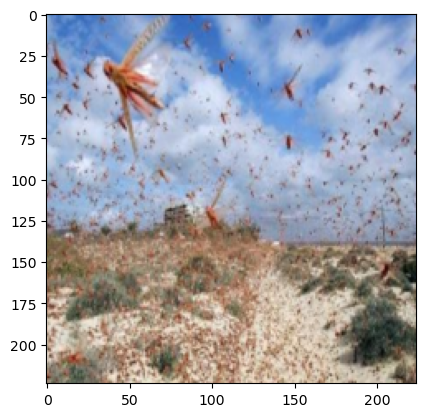

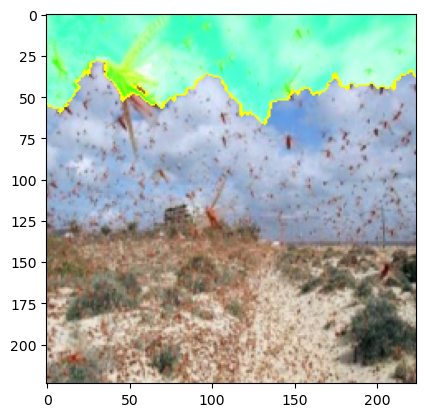

=====IMAGE 5=====


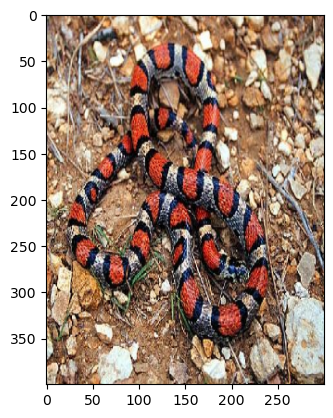

100%|██████████| 1000/1000 [00:08<00:00, 122.44it/s]


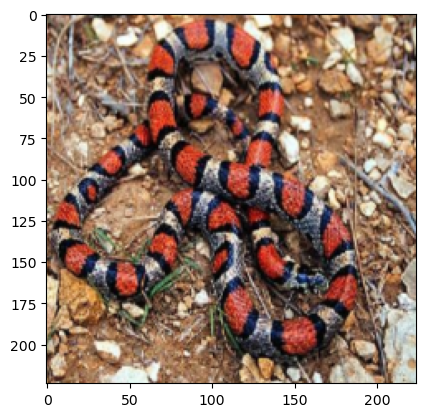

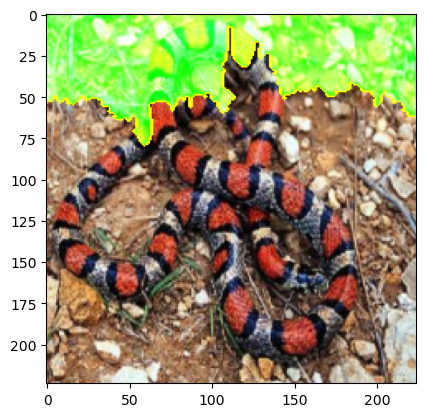

=====IMAGE 6=====


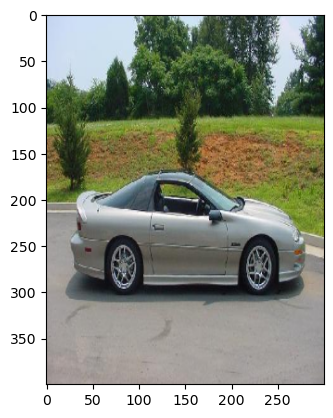

100%|██████████| 1000/1000 [00:08<00:00, 117.55it/s]


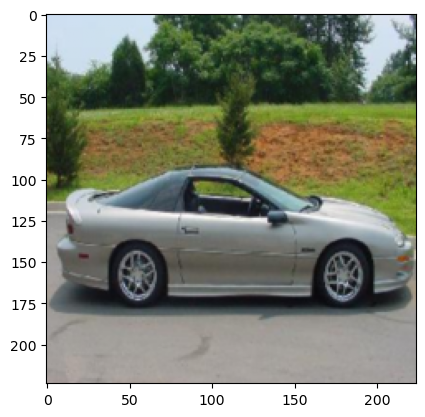

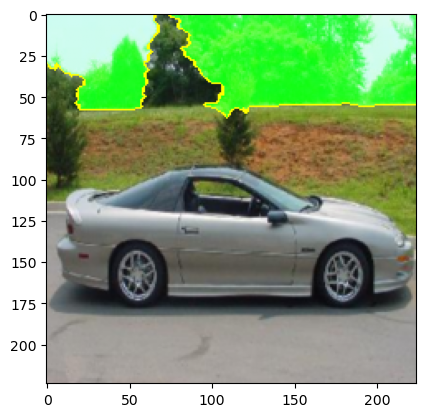

=====IMAGE 7=====


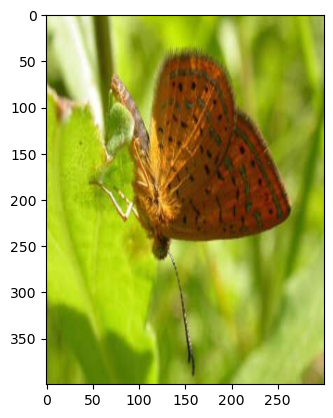

100%|██████████| 1000/1000 [00:08<00:00, 122.67it/s]


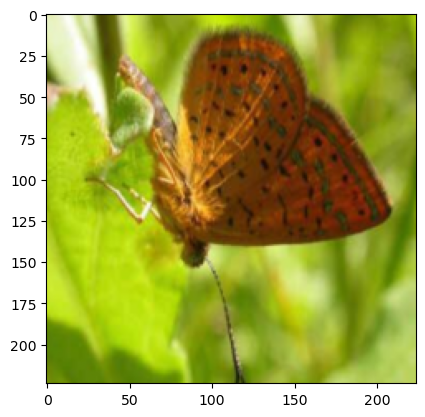

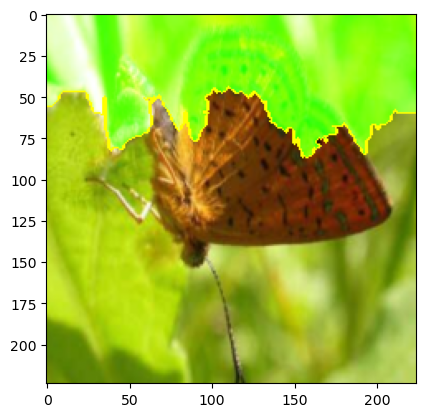

=====IMAGE 8=====


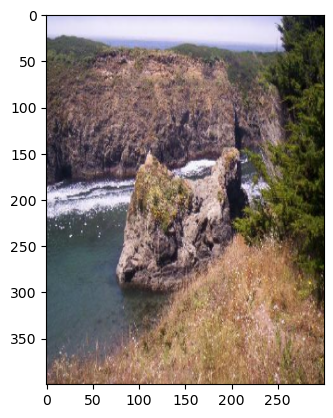

100%|██████████| 1000/1000 [00:08<00:00, 119.84it/s]


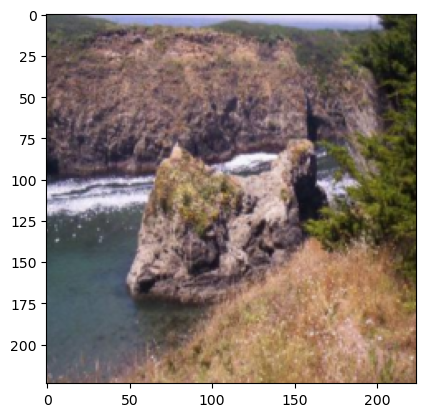

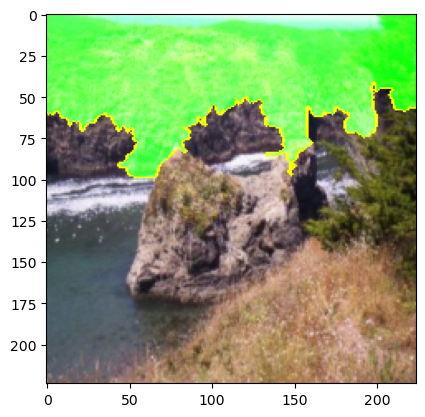

=====IMAGE 9=====


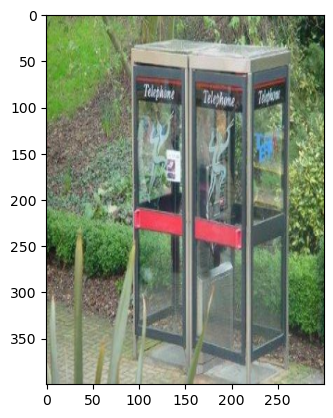

100%|██████████| 1000/1000 [00:08<00:00, 122.25it/s]


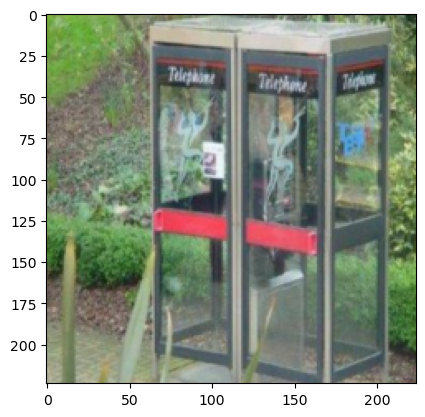

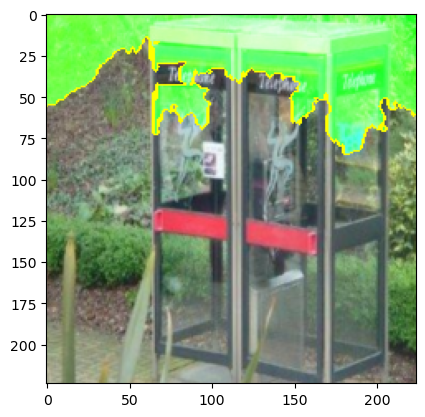

In [4]:
#code from: https://github.com/marcotcr/lime/blob/master/doc/notebooks/Tutorial%20-%20images%20-%20Pytorch.ipynb
import pandas as pd
import os
def get_image(path):
    with open(os.path.abspath(path), 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB') 

data_path = f"data/validation/unit{unit_used}.csv"
df = pd.read_csv(data_path)

for i in range(len(df)):
    print(f"=====IMAGE {i}=====")
    img_path = df.iloc[i]["image"]
    label = df.iloc[i]["label"]

    img = get_image(img_path)
    plt.imshow(img)
    plt.show()

    # resize and take the center part of image to what our model expects
    def get_input_transform():
        normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                        std=[0.229, 0.224, 0.225])       
        transf = torchvision.transforms.Compose([
            torchvision.transforms.Resize((256, 256)),
            torchvision.transforms.CenterCrop(224),
            torchvision.transforms.ToTensor(),
            normalize
        ])    

        return transf

    def get_input_tensors(img):
        transf = get_input_transform()
        # unsqeeze converts single image to batch of 1
        return transf(img).unsqueeze(0)

    def get_pill_transform(): 
        transf = torchvision.transforms.Compose([
            torchvision.transforms.Resize((256, 256)),
            torchvision.transforms.CenterCrop(224)
        ])    

        return transf

    def get_preprocess_transform():
        normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                        std=[0.229, 0.224, 0.225])     
        transf = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            normalize
        ])    

        return transf

    preprocess_transform = get_preprocess_transform()
    def batch_predict(images):
        model.eval()
        batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model.to(device)
        batch = batch.to(device)
        
        logits = model(batch)
        probs = torch.nn.functional.softmax(logits, dim=1)
        return probs.detach().cpu().numpy()

    #Evalute the model using LIME
    from lime import lime_image
    lime_explainer = lime_image.LimeImageExplainer()
    pill_transf = get_pill_transform()
    #print(np.shape(pil_trans(img).numpy()))
    explanation = lime_explainer.explain_instance(
        np.array(pill_transf(img)),
        batch_predict,
        top_labels=1,
        hide_color=0,
        num_samples=1000
    )

    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
    img_boundry1 = skimage.segmentation.mark_boundaries(temp/255.0, mask)
    plt.imshow(img_boundry1)
    plt.show()

    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
    img_boundry2 = skimage.segmentation.mark_boundaries(temp/255.0, mask)
    plt.imshow(img_boundry2)
    plt.show()